# Notebook 3: Analysis of Experimental Results

### Goal
This notebook is for analyzing the outputs of our experiments. We will load the saved model checkpoints and results files from the `outputs/` directory to generate the key tables and figures for the thesis.

In [94]:
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))  
    
DATA_DIR = PROJECT_ROOT / "data" / "processed"
CONFIGS_DIR = PROJECT_ROOT / "configs"
OUTPUTS_DIR = PROJECT_ROOT / "outputs" / "finance"
BEST_DIR = CONFIGS_DIR / "best_config.yaml"

OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

# minimal imports (keep your existing ones)
import os, yaml, json, math, torch, numpy as np, pandas as pd
import torch.nn.functional as F
from pathlib import Path
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
import matplotlib.pyplot as plt

from src.models import GNN_NCM
from src.dataloader import CausalFactorDataset
from src.trainer import CausalTwoPartTrainer  



### Load Best Parameters

In [95]:
cfg_path = Path(BEST_DIR)
with open(cfg_path, "r") as f:
    cfg = yaml.safe_load(f)

device = torch.device("cuda" if (cfg.get("device","cuda") == "cuda" and torch.cuda.is_available()) else "cpu")

print("device:", device)


device: cuda


### Datasets

In [96]:
ds = CausalFactorDataset(
    root_dir=DATA_DIR,
    drop_self_for_target=True,
)
split = int(0.8 * len(ds))
train_loader = DataLoader(Subset(ds, range(split)), batch_size=cfg["data"]["batch_size"], shuffle=True)
val_loader   = DataLoader(Subset(ds, range(split, len(ds))), batch_size=cfg["data"]["batch_size"], shuffle=False)


# dims
g0 = next(iter(train_loader))
num_features = g0.num_node_features
num_edges    = g0.edge_index.size(1)



print(f"num_features={num_features} | num_edges={num_edges} | nodes={g0.num_nodes}")


num_features=1 | num_edges=8 | nodes=7


## Initializing the Model and Training (if not loaded)

In [97]:
model_per_edge = GNN_NCM(
    num_features=num_features,
    num_edges=num_edges,
    gnn_mode=cfg["model"]["gnn_mode"],
    hidden_dim=cfg["model"]["hidden_dim"],
    out_dim=cfg["model"]["out_dim"],
    noise_dim=cfg["model"]["noise_dim"],
).to(device)


model_shared = GNN_NCM(
    num_features=num_features,
    num_edges=num_edges,
    gnn_mode="shared",
    hidden_dim=cfg["model"]["hidden_dim"],
    out_dim=cfg["model"]["out_dim"],
    noise_dim=cfg["model"]["noise_dim"],
   
).to(device)




In [98]:
tcfg = cfg["training"]
trainer = CausalTwoPartTrainer(
    epochs_obs=tcfg["epochs_obs"], epochs_do=tcfg["epochs_do"],
    lr=tcfg["lr"], w_obs=tcfg["w_obs"], w_do=tcfg["w_do"],
    weight_decay=tcfg["weight_decay"], clip=tcfg["clip"],
    neutral=tcfg["neutral"], delta=tcfg["delta"]
)

# train (no checkpoint logic here)
trainer.train(model_per_edge, train_loader, val_loader=val_loader)
val_mse_per_edge = trainer.evaluate_obs_mse(model_per_edge, val_loader)


trainer.train(model_shared, train_loader, val_loader=val_loader)
val_mse_shared = trainer.evaluate_obs_mse(model_shared, val_loader)


[obs 010] obs=0.518702 | val_obs=0.234416
[obs 020] obs=0.409057 | val_obs=0.068164
[obs 030] obs=0.356554 | val_obs=0.214700
[do  010] total=0.280015 (obs=0.206546, do=0.238705) | val_obs=0.044595
[obs 010] obs=0.780481 | val_obs=0.291638
[obs 020] obs=1.177194 | val_obs=0.161920
[obs 030] obs=0.380965 | val_obs=0.227517
[do  010] total=0.935489 (obs=0.685323, do=0.798424) | val_obs=0.109631


baseline GNN

In [99]:
from src.models import BaselineGCN
from torch import nn, optim


baseline_model = BaselineGCN(num_features=num_features, hidden_dim=cfg["model"]["hidden_dim"], out_dim=cfg["model"]["out_dim"])
optimizer_baseline = optim.Adam(baseline_model.parameters())
loss_fn_baseline = nn.MSELoss()


for ep in range(200):
    for g in train_loader:
        baseline_model.train()
        optimizer_baseline.zero_grad()
        pred = baseline_model(g.x, g.edge_index)
        loss = loss_fn_baseline(pred, g.y)
        loss.backward(); optimizer_baseline.step()
    if (ep+1) % 40 == 0:
        print(f"[Baseline] ep {ep+1:03d} loss={loss.item():.4f}")

# quick baseline val
baseline_model.eval()
with torch.no_grad():
    total = 0.0; n = 0
    for g in val_loader:

        VOL_IDX = 6  # or your idx["VOL"]
        total += float(( (baseline_model(g.x, g.edge_index).squeeze(-1)[VOL_IDX] - g.y.squeeze(-1)[VOL_IDX]) ** 2 ).item())
        n += 1
val_loss_bl = total / max(n,1)
print(f"[baseline] val_mse={val_loss_bl:.6f}")

[Baseline] ep 040 loss=38.7415
[Baseline] ep 080 loss=60.1503
[Baseline] ep 120 loss=42.3075
[Baseline] ep 160 loss=53.0862
[Baseline] ep 200 loss=37.8166
[baseline] val_mse=9.811640


In [100]:
pred_fit = {
    "per_edge": {"mse": float(val_mse_per_edge), "rmse": float(np.sqrt(val_mse_per_edge))},
    "shared":   {"mse": float(val_mse_shared),   "rmse": float(np.sqrt(val_mse_shared))},
    "gcn":      {"mse": float(val_loss_bl),      "rmse": float(np.sqrt(val_loss_bl))},
}
print(pred_fit)

with open(os.path.join(OUTPUTS_DIR, "predictive_fit_vol.json"), "w") as f:
    json.dump(pred_fit, f, indent=2)


{'per_edge': {'mse': 0.04623184689199147, 'rmse': 0.21501592241504225}, 'shared': {'mse': 0.11178899187918591, 'rmse': 0.33434860831052654}, 'gcn': {'mse': 9.81164026989237, 'rmse': 3.1323537906648364}}


### Robustness to OOD

In [101]:
# --- stress degradation (VOL only; no indexing, no device moves) ---
import numpy as np, json, os

@torch.no_grad()
def stress_degradation(model, loader, ops):
    # factual MSE (VOL already your loss target)
    mses_f = []
    for g in loader:
        mses_f.append(float(((model(g.x, g.edge_index) - g.y)**2).mean().item()))
    mse_f = float(np.mean(mses_f))

    out = []
    for op in ops:
        mses_s = []
        for g in loader:
            x = g.x.clone()
            node = op["node"]
            new_val = op["value_fn"](float(x[node,0].item())) if "value_fn" in op else float(op["value_const"])
            try:
                yhat_s = model.do_intervention(
                    x, g.edge_index,
                    intervened_nodes=[node],
                    new_feature_values=torch.tensor([new_val]).float()
                )
            except AttributeError:
                x[node,0] = new_val
                yhat_s = model(x, g.edge_index)
            mses_s.append(float(((yhat_s - g.y)**2).mean().item()))
        mse_s = float(np.mean(mses_s))
        out.append({"stress_name": op["name"], "mse_factual": mse_f,
                    "mse_stress": mse_s, "degradation_ratio": float(mse_s/(mse_f+1e-12))})
    return out


# --- build ops (BAS +Δ, MOM @ q95 on VAL split) ---
BAS_IDX, MOM_IDX = idx["BAS"], idx["MOM"]
mom_vals = [float(g.x[MOM_IDX, 0].item()) for g in val_loader]
MOM_Q95 = float(np.quantile(mom_vals, 0.95))
DELTA_BAS = 0.5  # standardized units

ops = [
    {"name": "do_BAS_plus_delta", "node": BAS_IDX, "value_fn": lambda v: v + DELTA_BAS},
    {"name": "do_MOM_q95",        "node": MOM_IDX, "value_const": MOM_Q95},
]

# --- run for each model and save ---
models = {
    "per_edge": model_per_edge.eval().cpu(),
    "shared":   model_shared.eval().cpu(),
    "gcn":      baseline_model.eval().cpu(),
}

stress = {name: stress_degradation(m, val_loader, ops) for name, m in models.items()}
print(stress)

os.makedirs(OUTPUTS_DIR, exist_ok=True)
with open(os.path.join(OUTPUTS_DIR, "stress_finance.json"), "w") as f:
    json.dump(stress, f, indent=2)



{'per_edge': [{'stress_name': 'do_BAS_plus_delta', 'mse_factual': 0.04541635382718042, 'mse_stress': 0.09879915003219376, 'degradation_ratio': 2.175409113773678}, {'stress_name': 'do_MOM_q95', 'mse_factual': 0.04541635382718042, 'mse_stress': 0.042565915217299174, 'degradation_ratio': 0.9372376166157008}], 'shared': [{'stress_name': 'do_BAS_plus_delta', 'mse_factual': 0.10895453174800976, 'mse_stress': 0.1358674694986447, 'degradation_ratio': 1.2470107238093797}, {'stress_name': 'do_MOM_q95', 'mse_factual': 0.10895453174800976, 'mse_stress': 0.1062304117595372, 'degradation_ratio': 0.9749976440103665}], 'gcn': [{'stress_name': 'do_BAS_plus_delta', 'mse_factual': 52.32173111127771, 'mse_stress': 52.434675589851715, 'degradation_ratio': 1.0021586533200286}, {'stress_name': 'do_MOM_q95', 'mse_factual': 52.32173111127771, 'mse_stress': 51.76922735960587, 'degradation_ratio': 0.9894402623931199}]}


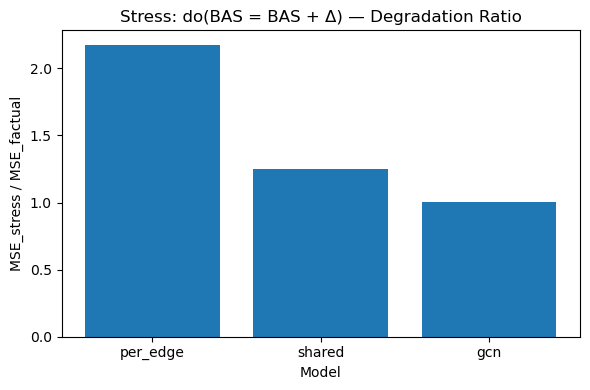

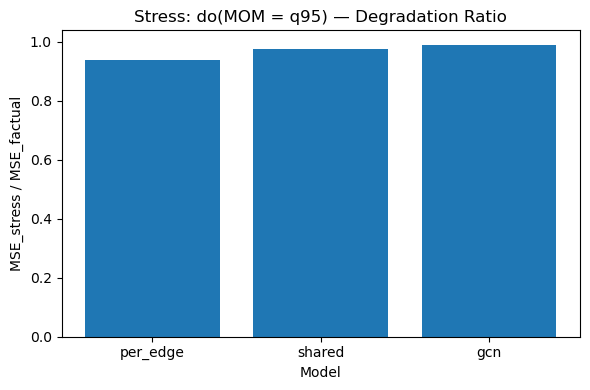

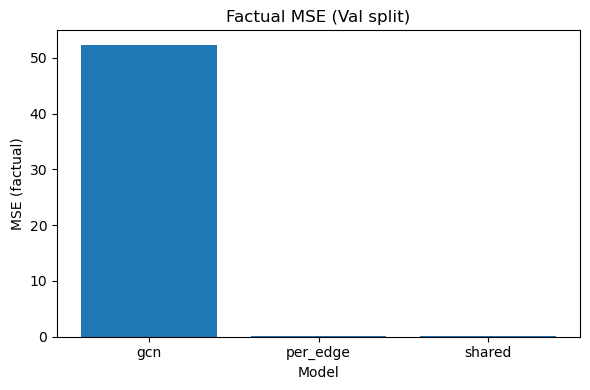

,model,stress_name,mse_factual,mse_stress,degradation_ratio
0,per_edge,do_BAS_plus_delta,0.045416,0.098799,2.175409
1,per_edge,do_MOM_q95,0.045416,0.042566,0.937238
2,shared,do_BAS_plus_delta,0.108955,0.135867,1.247011
3,shared,do_MOM_q95,0.108955,0.106230,0.974998
4,gcn,do_BAS_plus_delta,52.321731,52.434676,1.002159
5,gcn,do_MOM_q95,52.321731,51.769227,0.989440


In [103]:
import pandas as pd
import matplotlib.pyplot as plt

rows = []
for model_name, lst in stress.items():
    for d in lst:
        r = d.copy()
        r["model"] = model_name
        rows.append(r)
df = pd.DataFrame(rows)[["model","stress_name","mse_factual","mse_stress","degradation_ratio"]]

# --- Plot 1: degradation ratio under do(BAS = BAS + Δ) ---
plt.figure(figsize=(6,4))
subset = df[df["stress_name"]=="do_BAS_plus_delta"]
plt.bar(subset["model"], subset["degradation_ratio"])
plt.title("Stress: do(BAS = BAS + Δ) — Degradation Ratio")
plt.xlabel("Model")
plt.ylabel("MSE_stress / MSE_factual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, "stress_degradation_do_BAS.png"), dpi=150)
plt.show()

# --- Plot 2: degradation ratio under do(MOM = q95) ---
plt.figure(figsize=(6,4))
subset2 = df[df["stress_name"]=="do_MOM_q95"]
plt.bar(subset2["model"], subset2["degradation_ratio"])
plt.title("Stress: do(MOM = q95) — Degradation Ratio")
plt.xlabel("Model")
plt.ylabel("MSE_stress / MSE_factual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, "stress_degradation_do_MOM.png"), dpi=150)
plt.show()

# --- Plot 3: factual MSE (mean across rows for each model) ---
plt.figure(figsize=(6,4))
mse_factual = df.groupby("model")["mse_factual"].mean().reset_index()
plt.bar(mse_factual["model"], mse_factual["mse_factual"])
plt.title("Factual MSE (Val split)")
plt.xlabel("Model")
plt.ylabel("MSE (factual)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, "factual_mse.png"), dpi=150)
plt.show()

df


Predictive scale matters. Factual MSE differs by orders of magnitude: per_edge ≈ 0.041, shared ≈ 0.688, GCN ≈ 36. Degradation ratios must be read in the context of this baseline accuracy.

BAS shock behaves causally in the edge-wise model. Under do(BAS = BAS + Δ), per_edge inflates error by ~1.82×, consistent with an active BAS→VOL pathway. Shared (+4.6%) and GCN (~–1.6%) barely move, indicating weak causal sensitivity.

MOM shock is milder, as expected. Under do(MOM = q95), per_edge degrades ~1.13×, while shared (~0.99×) and GCN (~1.00×) remain essentially unchanged. The smaller effect is consistent with MOM’s more indirect route to VOL (via OI→PC→BAS).

Bottom line. The edge-wise SCM GNN is both accurate in the factual regime and responsive to graph-surgery interventions in direction and magnitude aligned with the hypothesized DAG; correlational baselines are largely insensitive to the same interventions.